# Introduction

This notebook will take a data-driven approach to generating word lists for mental functions that are related to brain circuitry. The overall process is as follows:

1. Cluster brain structures into circuits by PMI-weighted co-occurrences with mental function terms.
2. Identify the mental function terms most highly associated to each circuit over a range of list lengths.
3. Select the list length for each circuit that maximizes word-structure classification performance. 
4. Select the number of circuits that maximizes circuit-function classification performance.

# Load the data

In [1]:
import numpy as np
np.random.seed(42)

import pandas as pd
import sys
sys.path.append("..")
import utilities, ontology

In [2]:
suffix = "terms"
vsm_version = 190428 # Version of GloVe embeddings
dtm_version = 190325 # Version of document-term matrix

## Terms for mental functions

In [3]:
dtm_bin = utilities.load_doc_term_matrix(version=dtm_version, binarize=True)

In [4]:
lexicon = utilities.load_lexicon(["cogneuro"])
lexicon = sorted(list(set(lexicon).intersection(dtm_bin.columns)))
len(lexicon)

1683

## Document-term matrix

In [5]:
dtm_bin = dtm_bin[lexicon]
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=1683


## Document splits

In [6]:
train, val = [[int(pmid.strip()) 
               for pmid in open("../data/splits/{}.txt".format(split))] 
                    for split in ["train", "validation"]]
print("Training N={}, Validation N={}".format(len(train), len(val)))

Training N=12708, Validation N=3631


# Compute term co-occurrences

In [7]:
ttm = np.dot(dtm_bin.loc[train].transpose(), dtm_bin.loc[train])
print("Term N={}, Term N={}".format(ttm.shape[0], ttm.shape[1]))

Term N=1683, Term N=1683


In [8]:
ttm = pd.DataFrame(ttm, index=lexicon, columns=lexicon)
ttm.head()

,3d_object,abductive_reasoning,abstract_analogy,abstract_concrete_task,abstract_knowledge,abstract_pattern,abstract_task,abstractconcrete_task,acoustic_encoding,acoustic_phonetic_processing,...,working_memory_storage,working_memory_updating,write,writing,writing_paradigm,writing_task,young_mania_rating_scale,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
3d_object,126.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,1.0,0.0,4.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0
abductive_reasoning,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abstract_analogy,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
abstract_concrete_task,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
abstract_knowledge,0.0,0.0,0.0,0.0,29.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


## Reweight by PMI

In [9]:
ttm = ontology.pmi(ttm, positive=False)
ttm = pd.DataFrame(ttm, index=lexicon, columns=lexicon)
ttm = ttm.fillna(0.0)
ttm.head()

,3d_object,abductive_reasoning,abstract_analogy,abstract_concrete_task,abstract_knowledge,abstract_pattern,abstract_task,abstractconcrete_task,acoustic_encoding,acoustic_phonetic_processing,...,working_memory_storage,working_memory_updating,write,writing,writing_paradigm,writing_task,young_mania_rating_scale,zimbardo_time_perspective_inventory,zoo_map_test,zuckerman_sensation_seeking_scale
3d_object,4.310513,0.000000,0.000000,0.00000,0.000000,0.629184,0.443459,0.0,0.0,0.0,...,0.331441,0.0,-0.123028,-0.746109,0.0,0.741230,0.0,0.0,0.0,0.0
abductive_reasoning,0.000000,8.722127,0.000000,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0
abstract_analogy,0.000000,0.000000,8.516739,0.00000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,1.482662,0.0,0.000000,0.0,0.0,0.0,0.0
abstract_concrete_task,0.000000,0.000000,0.000000,8.24926,0.000000,0.000000,4.281667,0.0,0.0,0.0,...,0.000000,0.0,2.328886,1.146189,0.0,4.579438,0.0,0.0,0.0,0.0
abstract_knowledge,0.000000,0.000000,0.000000,0.00000,5.818435,2.117638,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.672279,-0.510418,0.0,0.000000,0.0,0.0,0.0,0.0


# Generate the ontology

## 1. Cluster functions by PMI-weighted co-occurrences

In [10]:
import os
from sklearn.cluster import KMeans
from scipy.stats import pointbiserialr

In [11]:
k = 6
clust_file = "data/clusters_terms_k{:02d}.csv".format(k)

In [12]:
kmeans = KMeans(n_clusters=k, max_iter=1000, random_state=42)  
kmeans.fit(ttm.values)
clust = pd.DataFrame({"TERM": ttm.index, 
                      "CLUSTER": [l+1 for l in list(kmeans.labels_)]})
clust = clust.sort_values(["CLUSTER", "TERM"])
clust.to_csv(clust_file, index=None)
clust.head()

,TERM,CLUSTER
20,active_retrieval,1
62,animacy_decision,1
91,association_learning,1
139,auditory_sentence_recognition,1
151,autobiographical_memory,1


## 2. Identify associated terms for mental functions

In [13]:
list_lens = range(5, 26)

In [14]:
lists = pd.DataFrame()
lists_file = "lists/lists_terms_k{:02d}.csv".format(k)
for i in range(k):
    terms = list(clust.loc[clust["CLUSTER"] == i+1, "TERM"])
    centroid = np.mean(dtm_bin.loc[train, terms], axis=1)
    R = pd.Series([pointbiserialr(dtm_bin.loc[train, term], centroid)[0] 
                   for term in dtm_bin.columns], index=dtm_bin.columns)
    R = R[R > 0].sort_values(ascending=False)[:max(list_lens)]
    R = pd.DataFrame({"CLUSTER": [i+1 for l in range(max(list_lens))], 
                      "TOKEN": R.index, "R": R.values})
    lists = lists.append(R)
lists.to_csv(lists_file, index=None)
lists.head()

/anaconda3/envs/ontol/lib/python3.6/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,CLUSTER,TOKEN,R
0,1,memory,0.748695
1,1,retrieval,0.645097
2,1,episodic_memory,0.631942
3,1,encoding,0.630381
4,1,recognition_memory,0.621858


## 3. Select number of words per domain

Optimize by semantic similarity to centroid of seed terms

In [15]:
from collections import OrderedDict
from scipy.spatial.distance import cosine

In [16]:
doms = list(OrderedDict.fromkeys(lists["CLUSTER"]))

In [17]:
vsm = pd.read_csv("../data/text/glove_gen_n100_win15_min5_iter500_{}.txt".format(vsm_version), 
                    index_col=0, header=None, sep=" ")
print("Vocab N={}, Embedding N={}".format(vsm.shape[0], vsm.shape[1]))

Vocab N=350544, Embedding N=100


In [18]:
ops = []
seed_df = lists
df = pd.DataFrame(index=doms, columns=list_lens)
for dom in doms:
    seed_tkns = seed_df.loc[seed_df["CLUSTER"] == dom, "TOKEN"]
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    for list_len in list_lens:
        len_tkns = lists.loc[lists["CLUSTER"] == dom, "TOKEN"][:list_len]
        len_centroid = np.mean(vsm.loc[len_tkns])
        df.loc[dom, list_len] = 1 - cosine(seed_centroid, len_centroid)
    sims = list(df.loc[dom])
    idx = sims.index(max(sims))
    ops.append(np.array(list_lens)[idx])
df["OPTIMAL"] = ops
df.to_csv("data/df_terms_opsim.csv")
df.head()

,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,25,OPTIMAL
1,0.966122,0.963748,0.965544,0.971303,0.970494,0.976844,0.976042,0.981244,0.984165,0.981972,...,0.984969,0.991384,0.994167,0.993268,0.994258,0.996395,0.99763,0.99917,1,25
2,0.934435,0.960121,0.967998,0.967493,0.97647,0.980714,0.980724,0.984996,0.989124,0.989644,...,0.992114,0.992587,0.991554,0.99498,0.996084,0.996631,0.998161,0.99923,1,25
3,0.95006,0.953095,0.956563,0.959211,0.975292,0.978641,0.98458,0.983704,0.982553,0.985585,...,0.991066,0.992284,0.994865,0.995477,0.997311,0.99793,0.998856,0.999295,1,25
4,0.962639,0.96434,0.95735,0.967272,0.969881,0.970392,0.971341,0.977131,0.980173,0.981293,...,0.985213,0.987976,0.99149,0.993938,0.995208,0.995041,0.996128,0.998798,1,25
5,0.932401,0.935368,0.936622,0.945363,0.955298,0.962805,0.962971,0.966175,0.969054,0.969873,...,0.983628,0.983547,0.986916,0.987101,0.994256,0.994062,0.997106,0.9987,1,25


In [19]:
columns = ["CLUSTER", "TOKEN", "R", "SIMILARITY"]
new = pd.DataFrame(columns=columns)
for order, dom in enumerate(doms):
    list_len = df.loc[dom, "OPTIMAL"]
    dom_df = lists.loc[lists["CLUSTER"] == dom][:list_len]
    new = new.append(dom_df)
    seed_tkns = seed_df.loc[seed_df["CLUSTER"] == dom, "TOKEN"]
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    new_tkns = list(new.loc[new["CLUSTER"] == dom, "TOKEN"])
    for tkn in new_tkns:
        new_vec = vsm.loc[tkn]
        new.loc[(new["CLUSTER"] == dom) & (new["TOKEN"] == tkn), "SIMILARITY"] = 1.0 - cosine(seed_centroid, new_vec)
new = new[columns]
new = new.sort_values(["CLUSTER", "R"], ascending=[True, False])
new.to_csv("lists/lists_terms_k{:02d}_opsim.csv".format(k), index=None)
new.head(50)

/anaconda3/envs/ontol/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,CLUSTER,TOKEN,R,SIMILARITY
0,1,memory,0.748695,0.918754
1,1,retrieval,0.645097,0.889372
2,1,episodic_memory,0.631942,0.841198
3,1,encoding,0.630381,0.879681
4,1,recognition_memory,0.621858,0.810194
5,1,remembering,0.600270,0.710969
6,1,memory_retrieval,0.547053,0.808499
7,1,recall,0.523471,0.812149
8,1,recognition,0.482598,0.787357
9,1,longterm_memory,0.465787,0.794974


# Name the domains

In [20]:
lists = new
op_k = 6

## Select the term with highest degree centrality

Also ensure that names are unique across domains in the clustering solution

In [21]:
title_df = pd.read_csv("../lexicon/labels_cogneuro.csv", index_col=None, header=0)
term2title = {term.upper(): title.upper().replace(" ", "_") for term, title in zip(title_df["TERM"], title_df["TITLE"])}

In [22]:
k2terms = {i: list(set(lists.loc[lists["CLUSTER"] == i+1, "TOKEN"])) for i in range(op_k)}
k2name = {i+1: "" for i in range(op_k)}
names, degs = [""]*op_k, [0]*op_k
while "" in names:
    for i in range(op_k):
        degrees = ontology.term_degree_centrality(i+1, lists, dtm_bin, dtm_bin.index)
        degrees = degrees.loc[k2terms[i]].sort_values(ascending=False)
        name = degrees.index[0].upper()
        name = ontology.nounify(name, term2title)
        if name not in names:
            names[i] = name
            degs[i] = max(degrees)
            k2name[i+1] = name
        elif name in names:
            name_idx = names.index(name)
            if degs[name_idx] > degs[i]:
                k2terms[i] = [term for term in k2terms[i] if term != name.lower()]
names

['MEMORY', 'COGNITION', 'LANGUAGE', 'EMOTION', 'INFERENCE', 'VISION']

## Sort by predetermined semantic ordering

In [23]:
order = [1,4,5,2,6,3]
k2order = {k: order.index(k)+1 for k in range(1,op_k+1)}
names = [k2name[k] for k in order]
names

['MEMORY', 'EMOTION', 'INFERENCE', 'COGNITION', 'VISION', 'LANGUAGE']

## Export ontology with domain names

### Function term lists

In [24]:
columns = ["ORDER", "CLUSTER", "DOMAIN", "TOKEN", "R", "SIMILARITY"]
lists["ORDER"] = [k2order[k] for k in lists["CLUSTER"]]
lists["DOMAIN"] = [k2name[k] for k in lists["CLUSTER"]]
lists = lists.sort_values(["ORDER", "R"], ascending=[True, False])
lists = lists[columns]
lists.to_csv("lists/lists_data-driven_terms.csv", index=None)
lists.head(50)

,ORDER,CLUSTER,DOMAIN,TOKEN,R,SIMILARITY
0,1,1,MEMORY,memory,0.748695,0.918754
1,1,1,MEMORY,retrieval,0.645097,0.889372
2,1,1,MEMORY,episodic_memory,0.631942,0.841198
3,1,1,MEMORY,encoding,0.630381,0.879681
4,1,1,MEMORY,recognition_memory,0.621858,0.810194
5,1,1,MEMORY,remembering,0.600270,0.710969
6,1,1,MEMORY,memory_retrieval,0.547053,0.808499
7,1,1,MEMORY,recall,0.523471,0.812149
8,1,1,MEMORY,recognition,0.482598,0.787357
9,1,1,MEMORY,longterm_memory,0.465787,0.794974


# Visualize the term lists

In [25]:
from style import style
%matplotlib inline

MEMORY


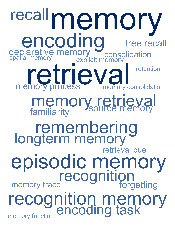

EMOTION


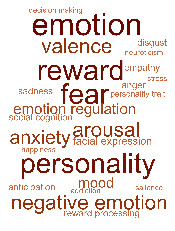

INFERENCE


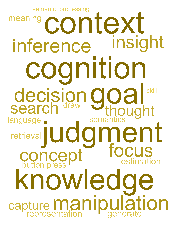

COGNITION


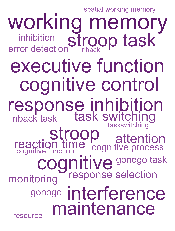

VISION


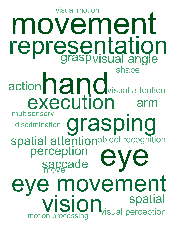

LANGUAGE


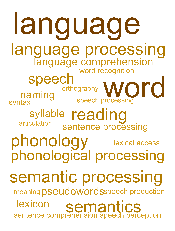

In [26]:
ontology.plot_wordclouds("data-driven", names, lists, metric="R", 
                         suffix="_terms", palette=style.palettes["data-driven"],
                         height=350, width=260, min_font_size=0, max_font_size=50,
                         brightness_offset=0.15, darkness_offset=-0.35, n_offsets=25)

# Visualize the circuits

In [27]:
from sklearn.preprocessing import binarize
from statsmodels.stats.multitest import multipletests
%matplotlib inline

## Compute PPMI-weighted links

In [28]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


In [29]:
dtm_bin = utilities.load_doc_term_matrix(version=dtm_version, binarize=True)

In [30]:
dom_scores = utilities.score_lists(lists, dtm_bin, label_var="DOMAIN")

In [31]:
pmids = act_bin.index.intersection(dom_scores.index)
len(pmids)

18155

In [32]:
act_bin = act_bin.loc[pmids]
dom_scores = dom_scores.loc[pmids]

In [33]:
dom_links = ontology.compute_cooccurrences(act_bin, dom_scores)

In [34]:
n_iter = 10000
dom_links_null = ontology.compute_cooccurrences_null(act_bin, dom_scores, 
                                                     n_iter=n_iter, verbose=True)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [35]:
p = pd.DataFrame(index=act_bin.columns, columns=dom_scores.columns)
for i, struct in enumerate(act_bin.columns):
    for j, dom in enumerate(dom_scores.columns):
        obs = dom_links.values[i,j]
        null = dom_links_null[i,j,:]
        p.loc[struct, dom] = np.sum(null > obs) / float(n_iter)

In [36]:
fdr = multipletests(p.values.ravel(), method="fdr_bh")[1]
fdr = pd.DataFrame(fdr.reshape(p.shape), 
                   index=act_bin.columns, columns=dom_scores.columns)

In [37]:
dom_links_thres = dom_links[fdr < 0.01]
dom_links_thres = dom_links_thres.fillna(0.0)

In [38]:
dom_links_thres.to_csv("circuits/circuits_data-driven_terms.csv")

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


MEMORY               Min: 0.0000  Mean: 0.0497  Max: 0.4022


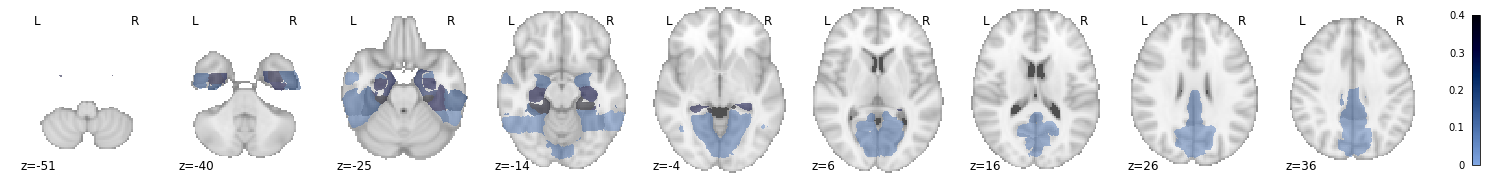

EMOTION              Min: 0.0000  Mean: 0.0798  Max: 0.5727


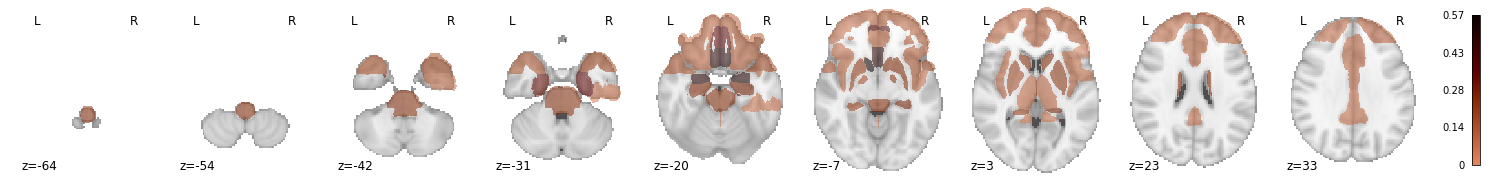

INFERENCE            Min: 0.0000  Mean: 0.0082  Max: 0.0818


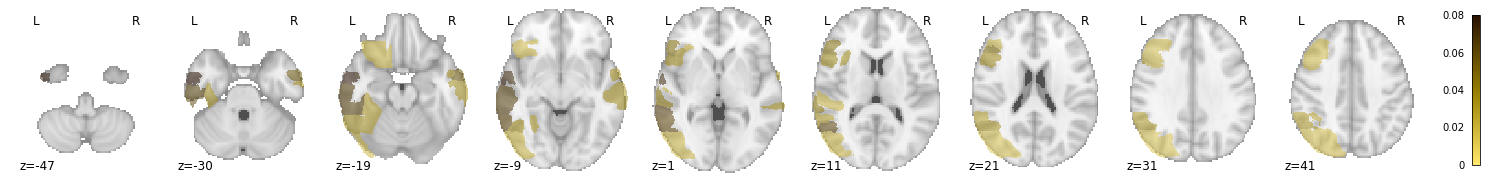

COGNITION            Min: 0.0000  Mean: 0.0218  Max: 0.1179


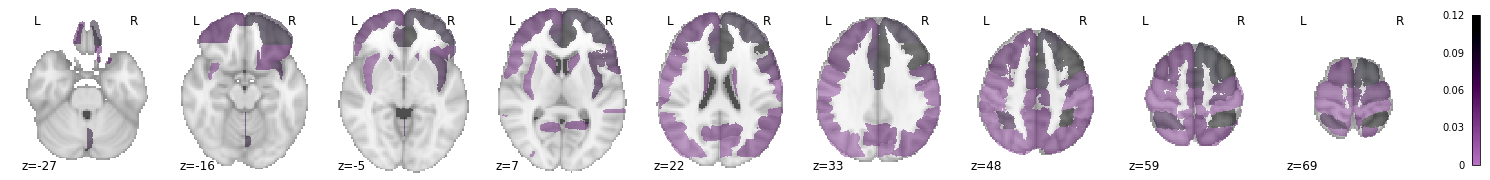

VISION               Min: 0.0000  Mean: 0.0419  Max: 0.2124


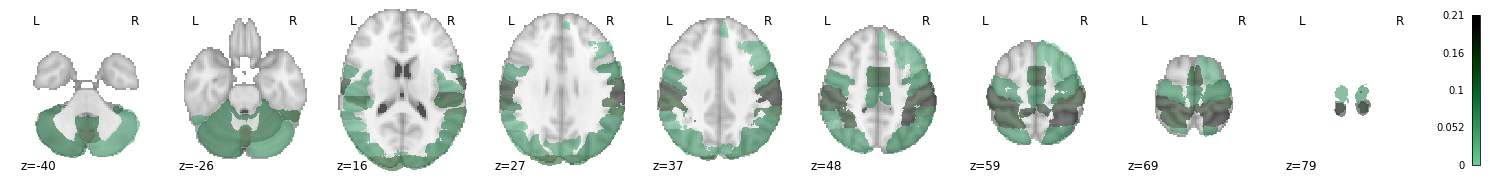

LANGUAGE             Min: 0.0000  Mean: 0.0456  Max: 0.3153


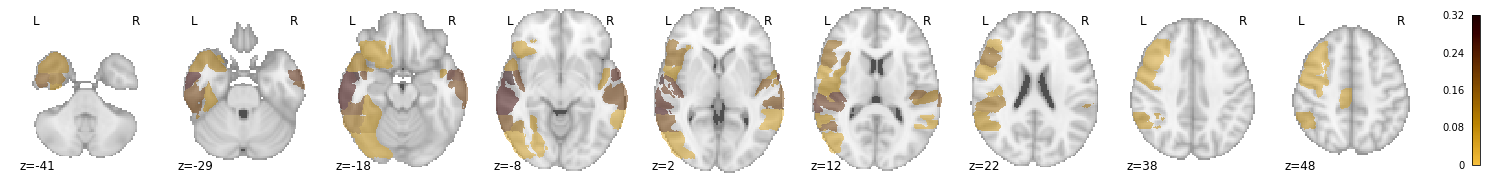

In [39]:
atlas = utilities.load_atlas()
path = "figures/circuits/data-driven_terms"
cmaps = style.colormaps["data-driven"]
vmaxs = [round(v, 2) for v in dom_links_thres.max()]
for plane, verbose in zip(["z", "x", "y"], [True, False, False]):
    utilities.map_plane(dom_links_thres, atlas, path, suffix="_"+plane, cut_coords=9,
                        cmaps=cmaps, plane=plane, cbar=True, vmin=0.0, vmaxs=vmaxs,
                        verbose=verbose, print_fig=verbose)